In [1]:
import os, random, numpy as np, torch
SEED = 7  # or the one you used before

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# If some ops complain, keep warn_only=True
torch.use_deterministic_algorithms(True, warn_only=True)

def seed_worker(worker_id):
    s = SEED + worker_id
    np.random.seed(s); random.seed(s)

g = torch.Generator()
g.manual_seed(SEED)
# Then pass: DataLoader(..., worker_init_fn=seed_worker, generator=g)


In [2]:
# ============================================
# Cell 1: Imports, utils, strict reproducibility
# ============================================
import os, math, random, time, csv, copy, json
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":16:8")

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def dump_task_artifact(task_id: int, payload: dict, art_dir: str):
    ensure_dir(art_dir)
    fname = os.path.join(art_dir, f"task_{task_id+1:02d}.json")
    with open(fname, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"[ART] Wrote {fname}")

SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

STRICT_REPRO = True
if STRICT_REPRO:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception:
        pass
else:
    torch.backends.cudnn.benchmark = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

g = torch.Generator(); g.manual_seed(SEED)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)


Device: cuda


In [3]:
# ============================================
# Cell 2: Config (CoCoNAS v3.2 champion)
# ============================================
# Dataset: CIFAR-100 → 10 tasks × 10 classes
NUM_CLASSES = 100
TASK_SIZE   = 10
TASKS       = [list(range(i, i+TASK_SIZE)) for i in range(0, NUM_CLASSES, TASK_SIZE)]

# Per-class quotas (keep sum <= 500 for CIFAR-100 train)
TRAIN_PER_CLASS = 400
VAL_PER_CLASS   = 100

# Exemplar budget for memory
EXEMPLAR_TOTAL_BUDGET = 2000

# Edge/latency profile (sim)
EDGE_PROFILE = os.environ.get("COCONAS_EDGE", "nano_int8")  # "none"|"nano_int8"|"xaviernx_fp16"|"orin_nano_fp16"
JETSON_SIM_FACTOR = {"nano_int8": 12.0, "xaviernx_fp16": 6.0, "orin_nano_fp16": 4.0}
JETSON_TARGET_MS  = {"nano_int8": 10.6, "xaviernx_fp16": 6.0, "orin_nano_fp16": 4.0}

# Reward & stability
REWARD_MODE = "lagrangian"
STAB_ALPHA  = 0.20
ENABLE_STAB_REWARD = True
STAB_GAMMA = 0.10
ENTROPY_WEIGHT_IN_REWARD = 0.01
USE_CVAR = True
CVAR_TAU = 0.20
CVAR_BATCHES = 8

# Constraint modes
RELAXED_CONSTRAINT = True
TIGHT_LAT_TARGET   = float(os.environ.get("COCONAS_LAT_MS", "10.6"))
if EDGE_PROFILE in JETSON_TARGET_MS:
    TIGHT_LAT_TARGET = JETSON_TARGET_MS[EDGE_PROFILE]
RELAXED_LAT_TARGET = 12.0
LAT_TARGET_MS = RELAXED_LAT_TARGET if RELAXED_CONSTRAINT else TIGHT_LAT_TARGET
LAT_SLACK_FRAC = 0.06
SLACK_BONUS    = 0.03  # small positive bump when clearly under target (optional, mild)

DUAL_LR    = 0.005
U_CLIP_MAX = 10.0
MARGIN_MS  = 0.0

# Controller/Population
MAX_HEADS = 16
POP_SIZE  = 6
RL_ITERS  = 600

# Controller exploration
TEMP_START, TEMP_END = 7.0, 0.9
EPS_FLOOR = 0.10
BOOTSTRAP_ROUNDS = 4

# Training
IMG_SIZE = 224
BATCH_SIZE   = 64
LR_WARMUP    = 1e-3
LR_RL        = 7e-4
LR_CONSOLID  = 5e-4
WD           = 1e-4
GRAD_CLIP    = 1.0

# Schedules
WARMUP_STEPS_PER_HEAD = 200
RL_TRAIN_STEPS_PER_PICK = 8
CONSOLIDATION_STEPS   = 300
BALANCED_FT_STEPS     = 150
EQ_STEPS              = 100  # <- fixed: equalized fine-tune

# Exploration of heads
RISK_DRIVEN_MUTATIONS = True
MUTATE_EVERY = 100
OFFSPRING_PER_CYCLE = 2
MAX_LAYERS = 4
WIDTH_CHUNK = 64
DROP_CHOICES = [0.0, 0.2, 0.5]
SAL_EMA_BETA = 0.9
SAL_MIN_STEPS = 50


# KD schedule with a hard cap at 0.65 (minimal change, no new globals required)
KD_BASE = 0.30
KD_STEP = 0.05

def kd_weight_for_task(task_id: int) -> float:
    w = KD_BASE + KD_STEP * task_id
    return float(min(w, 0.65))  # <-- hard cap

# HP grid for RL (keep modest)
from itertools import product
HP_GRID = {
    "KD_W":   [0.45, 0.60, 0.70],
    "KD_T":   [2.0, 3.0],
    "LR":     [7e-4, 5e-4],
    "REPLAY": [(0.60,0.25,0.15), (0.67,0.23,0.10)]
}
HP_KEYS    = list(HP_GRID.keys())
HP_OPTIONS = [HP_GRID[k] for k in HP_KEYS]
HP_ACTIONS = [dict(zip(HP_KEYS, vals)) for vals in product(*HP_OPTIONS)]

# Error-buffer & boosting
ERRBUF_CAPACITY_PER_TASK = 800
PRIORITY_ALPHA   = 0.6
HARD_PERCENTILE  = 0.75
BOOST_K_CLASSES  = 2
BOOST_FACTOR     = 2.0

# Artifacts
ART_DIR = "coconas_v32_artifacts"

FAST_DEBUG = False
try:
    print("KD schedule:", [round(kd_weight_for_task(t), 3) for t in range(len(TASKS))])
except NameError:
    pass



KD schedule: [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.65, 0.65]


In [4]:
# ============================================
# Cell 3: Datasets, robust splits, loaders
# ============================================
class IndexDataset(Dataset):
    def __init__(self, base: Dataset, indices: List[int]):
        self.base = base; self.indices = list(indices)
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        return img, int(label), int(self.indices[i])

def build_indices_by_class(base_plain: Dataset, num_classes=NUM_CLASSES):
    buckets = {c: [] for c in range(num_classes)}
    for i in range(len(base_plain)):
        _, y = base_plain[i]; buckets[int(y)].append(i)
    return buckets

def split_task_indices(train_buckets, cls_list, train_per=TRAIN_PER_CLASS, val_per=VAL_PER_CLASS):
    tr_idx, vo_idx = [], []
    for c in cls_list:
        idxs = list(train_buckets[c])
        n_avail = len(idxs)  # 500 for CIFAR-100 train
        if n_avail < train_per + val_per:
            new_train = min(train_per, n_avail // 2)
            new_val   = min(val_per, n_avail - new_train)
            print(f"[WARN] Class {c}: requested {train_per}+{val_per}>{n_avail}. "
                  f"Clamping to {new_train}+{new_val}.")
            _train_per, _val_per = new_train, new_val
        else:
            _train_per, _val_per = train_per, val_per
        random.Random(SEED + c).shuffle(idxs)
        tr_idx += idxs[:_train_per]
        vo_idx += idxs[_train_per:_train_per+_val_per]
    return tr_idx, vo_idx

# Transforms
train_base = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))
val_base   = torchvision.datasets.CIFAR100(root="./data", train=True,  download=False, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    # "Harsher" val can be done by *not* adding aug here; keep it clean.
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))
test_base  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))

# Label-only for strict indexing
plain_train = torchvision.datasets.CIFAR100(root="./data", train=True,  download=False, transform=T.ToTensor())
plain_test  = torchvision.datasets.CIFAR100(root="./data", train=False, download=False, transform=T.ToTensor())
train_buckets = build_indices_by_class(plain_train)
test_buckets  = build_indices_by_class(plain_test)

def make_task_splits(task_classes):
    tr_idx, vo_idx = split_task_indices(train_buckets, task_classes)
    te_idx = []
    for c in task_classes: te_idx += test_buckets[c]
    return IndexDataset(train_base, tr_idx), IndexDataset(val_base, vo_idx), IndexDataset(test_base, te_idx)

def make_test_dataset_for_task(task_classes):
    idx = []
    for c in task_classes: idx += test_buckets[c]
    return IndexDataset(test_base, idx)

def make_loader(ds, shuffle, bs=BATCH_SIZE, drop_last=False):
    if ds is None: return None
    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle, num_workers=2, pin_memory=True,
        drop_last=drop_last, worker_init_fn=seed_worker, generator=g,
    )

def leak_check(ds_train, ds_val):
    inter = set(ds_train.indices) & set(ds_val.indices)
    assert len(inter) == 0, f"LEAK: {len(inter)} overlapping samples!"

def leak_check_threeway(ds_train, ds_val, ds_test):
    s_tr, s_va = set(ds_train.indices), set(ds_val.indices)
    assert s_tr.isdisjoint(s_va), "LEAK: train↔val overlap"


100%|██████████| 169M/169M [08:46<00:00, 321kB/s]


In [5]:
# ============================================
# Cell 4: Backbone, FC heads, seed configs
# ============================================
from torchvision.models import resnet18

class BackboneGAP(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            m = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            try:
                m = resnet18(pretrained=True)
            except Exception:
                m = resnet18(weights=None)
        self.features = nn.Sequential(*list(m.children())[:-1])
        for p in self.features.parameters(): p.requires_grad = False
    def forward(self, x):
        x = self.features(x)
        return x.flatten(1)

class FCHead(nn.Module):
    def __init__(self, in_dim=512, hidden=[256], p_drop=0.0, out_dim=NUM_CLASSES):
        super().__init__()
        layers = []; prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(inplace=True)]
            if p_drop>0: layers += [nn.Dropout(p_drop)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)
        self.hidden = list(hidden); self.p_drop = p_drop
    def forward(self, z): return self.net(z)

WIDTH_SET   = [64, 128, 256, 384, 512]
DEPTH_RANGE = (0, MAX_LAYERS)

def make_seed_head_configs(n_random=8):
    rng = random.Random(SEED + 42)
    cfgs = []
    for _ in range(n_random):
        d = rng.randint(DEPTH_RANGE[0], DEPTH_RANGE[1])
        hidden = [rng.choice(WIDTH_SET) for _ in range(d)]
        p_drop = rng.choice(DROP_CHOICES)
        cfgs.append(dict(hidden=hidden, p_drop=p_drop))
    cfgs.append(dict(hidden=[], p_drop=0.0))
    cfgs.append(dict(hidden=[512,512,512,512][:MAX_LAYERS], p_drop=0.5))
    return cfgs

def build_seed_heads(out_dim=NUM_CLASSES):
    heads = {}
    for i, cfg in enumerate(make_seed_head_configs()):
        h = FCHead(out_dim=out_dim, **cfg).to(DEVICE)
        h._sal_tracker = None
        heads[f"H{i}"] = h
    return heads

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)

backbone = BackboneGAP().to(DEVICE).eval()
seed_heads = build_seed_heads()
print({k: {"hidden": v.hidden, "p_drop": v.p_drop} for k, v in seed_heads.items()})
print("Backbone ready; GAP=512. Seed heads:", len(seed_heads))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


{'H0': {'hidden': [128, 384], 'p_drop': 0.5}, 'H1': {'hidden': [256], 'p_drop': 0.2}, 'H2': {'hidden': [384], 'p_drop': 0.5}, 'H3': {'hidden': [64, 64, 384, 64], 'p_drop': 0.2}, 'H4': {'hidden': [256], 'p_drop': 0.5}, 'H5': {'hidden': [64, 256], 'p_drop': 0.5}, 'H6': {'hidden': [512, 512, 512], 'p_drop': 0.5}, 'H7': {'hidden': [], 'p_drop': 0.2}, 'H8': {'hidden': [], 'p_drop': 0.0}, 'H9': {'hidden': [512, 512, 512, 512], 'p_drop': 0.5}}
Backbone ready; GAP=512. Seed heads: 10


In [6]:
# ============================================
# Cell 5: Feature dataset (precompute z)
# ============================================
class FeatureDS(Dataset):
    def __init__(self, base_idx_ds: Dataset, backbone: nn.Module, bs=256):
        self.Z, self.Y, self.I = [], [], []
        loader = DataLoader(
            base_idx_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True,
            worker_init_fn=seed_worker, generator=g
        )
        backbone.eval()
        with torch.no_grad():
            for x,y,i in loader:
                z = backbone(x.to(DEVICE)).cpu()
                self.Z.append(z); self.Y.append(y.clone()); self.I.append(i.clone().cpu().int())
        self.Z = torch.cat(self.Z); self.Y = torch.cat(self.Y); self.I = torch.cat(self.I)
    def __len__(self): return self.Y.size(0)
    def __getitem__(self, k): return self.Z[k], int(self.Y[k]), int(self.I[k])


In [7]:
# ============================================
# Cell 6: Error buffer & exemplar memory
# ============================================
class ErrorBufferZ:
    def __init__(self, capacity=ERRBUF_CAPACITY_PER_TASK):
        self.capacity = capacity
        self.items = []
        self.per_class = defaultdict(int)
    def __len__(self): return len(self.items)
    def add_batch(self, z, y, losses, class_cap=80):
        z = z.detach().cpu(); y = y.detach().cpu(); losses = losses.detach().cpu()
        for i in range(len(y)):
            c = int(y[i])
            if self.per_class[c] >= class_cap: continue
            self.items.append({"z": z[i], "y": int(y[i]), "loss_val": float(losses[i]), "cls": c})
            self.per_class[c] += 1
        if len(self.items) > self.capacity:
            fifo_k = max(1, int(0.2*self.capacity))
            tail = self.items[-fifo_k:]
            rest = sorted(self.items[:-fifo_k], key=lambda d: d["loss_val"], reverse=True)[:self.capacity - fifo_k]
            self.items = rest + tail
    def sample(self, n, boost_classes=None, boost_factor=BOOST_FACTOR):
        if not self.items: return None
        w = torch.tensor([max(1e-6, d["loss_val"]) for d in self.items], dtype=torch.float)
        if boost_classes:
            for i,d in enumerate(self.items):
                if d["cls"] in boost_classes: w[i] *= boost_factor
        w = (w ** PRIORITY_ALPHA); w = w / w.sum()
        idx = torch.multinomial(w, num_samples=min(n, len(self.items)), replacement=False).tolist()
        Z, Y = [], []
        for i in idx: Z.append(self.items[i]["z"]); Y.append(self.items[i]["y"])
        return torch.stack(Z).to(DEVICE), torch.tensor(Y, device=DEVICE)

class ExemplarMemoryZ:
    def __init__(self, budget=EXEMPLAR_TOTAL_BUDGET, seed=0):
        self.budget = int(budget)
        self.store  = {}  # c -> [(z_cpu, c), ...]
        random.seed(seed)
    def size(self): return sum(len(v) for v in self.store.values())
    @torch.no_grad()
    def sample(self, n, seen_classes):
        items = []
        for c in seen_classes:
            items.extend(self.store.get(int(c), []))
        if len(items) == 0: return None
        take = min(int(n), len(items))
        idx  = np.random.choice(len(items), size=take, replace=(len(items) < take))
        z = torch.stack([items[i][0] for i in idx]).to(DEVICE)
        y = torch.tensor([items[i][1] for i in idx], device=DEVICE)
        return z, y
    @torch.no_grad()
    def update_after_task_risk(self, ds_train_z, per_class_k):
        # shrink big classes first
        for c, k in per_class_k.items():
            c = int(c); k = int(k)
            if c in self.store and len(self.store[c]) > k:
                self.store[c] = self.store[c][:k]
        # add new
        need = {int(c): max(0, int(per_class_k.get(int(c), 0)) - len(self.store.get(int(c), [])))
                for c in per_class_k.keys()}
        if sum(need.values()) > 0:
            for i in range(len(ds_train_z)):
                z, y, _ = ds_train_z[i]
                c = int(y)
                if c in need and need[c] > 0:
                    self.store.setdefault(c, []).append((z.cpu(), c))
                    need[c] -= 1
                    if sum(need.values()) == 0:
                        break
        total = self.size()
        if total > self.budget:
            scale = self.budget / float(total)
            for c in list(self.store.keys()):
                keep = max(0, int(round(len(self.store[c]) * scale)))
                self.store[c] = self.store[c][:keep]

exemplar_mem = ExemplarMemoryZ()


In [8]:
# ============================================
# Cell 7: Eval helpers, CVaR, latency, reward
# ============================================
criterion = nn.CrossEntropyLoss(reduction='none')

def seen_up_to(task_id: int):     return list(range((task_id+1)*TASK_SIZE))
def old_seen_up_to(task_id: int): return list(range(task_id*TASK_SIZE))

def mask_unseen_logits(logits: torch.Tensor, seen_classes):
    if not seen_classes: return logits
    mask = torch.full_like(logits, float("-inf"))
    mask[:, list(seen_classes)] = 0.0
    return logits + mask

def masked_ce(logits, y, seen_classes):
    if not seen_classes:
        return criterion(logits, y)
    mask = torch.full_like(logits, -1e9)
    mask[:, list(seen_classes)] = 0.0
    return criterion(logits + mask, y)

@torch.no_grad()
def logits_any(head, x):
    if x.dim() == 4:
        z = backbone(x.to(DEVICE))
    else:
        z = x.to(DEVICE)
    return head(z)

@torch.no_grad()
def eval_accuracy_any(backbone_unused, head, loader, seen_classes=None):
    if loader is None: return 0.0
    correct, total = 0, 0
    for x,y,_ in loader:
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); total += y.numel()
    return correct / max(1,total)

@torch.no_grad()
def accuracy_cvar(backbone_unused, head, loader, seen_classes=None, tau=CVAR_TAU, batches=CVAR_BATCHES):
    if loader is None: return 0.0
    accs = []
    for bi,(x,y,_) in enumerate(loader):
        if bi >= batches: break
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        accs.append((pred==y).float().mean().item())
    if not accs: return 0.0
    accs = sorted(accs)
    k = max(1, int(math.ceil(tau*len(accs))))
    return float(np.mean(accs[:k]))

@torch.no_grad()
def worst_k_classes_on_val_any(backbone_unused, head, val_loader, k=2, seen_classes=None):
    if k<=0 or val_loader is None: return []
    cls_c, cls_t = defaultdict(int), defaultdict(int)
    for x,y,_ in val_loader:
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        for yi,pi in zip(y.tolist(), pred.tolist()):
            cls_t[yi]+=1
            if yi==pi: cls_c[yi]+=1
    accs = [(c, cls_c[c]/max(1,cls_t[c])) for c in cls_t.keys()]
    accs.sort(key=lambda t: t[1])
    return [c for c,_ in accs[:k]]

@torch.no_grad()
def latency_stats_ms_per_image(backbone_model, head, bs=32, iters=60, warmup=20):
    model = nn.Sequential(backbone_model, head).to(DEVICE).eval()
    x = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
    times = []
    if DEVICE.type == 'cuda':
        s = torch.cuda.Event(enable_timing=True); e = torch.cuda.Event(enable_timing=True)
        for _ in range(warmup): _ = model(x); torch.cuda.synchronize()
        for _ in range(iters):
            s.record(); _ = model(x); e.record()
            torch.cuda.synchronize()
            times.append(s.elapsed_time(e) / bs)
    else:
        for _ in range(warmup): _ = model(x)
        for _ in range(iters):
            t0=time.time(); _ = model(x); t1=time.time()
            times.append((t1-t0)*1000.0/bs)
    t=torch.tensor(times)
    p50 = float(torch.quantile(t,0.5)); p95=float(torch.quantile(t,0.95))
    return p50, p95

def cache_head_latency_stats(head_dict, bs=32):
    stats={}
    for name, head in head_dict.items():
        p50,p95=latency_stats_ms_per_image(backbone, head, bs=bs)
        if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
        stats[name]={"p50":p50,"p95":p95}
    return stats

def compute_reward_any(
    head,
    val_loader_now,
    latency_p95_ms,
    dual_u=None,
    entropy_weight=ENTROPY_WEIGHT_IN_REWARD,
    seen_classes=None,
    prev_val_loader=None,
    prev_seen_classes=None,
):
    if USE_CVAR:
        acc_now = accuracy_cvar(None, head, val_loader_now, seen_classes=seen_classes)
    else:
        acc_now = eval_accuracy_any(None, head, val_loader_now, seen_classes=seen_classes)

    if prev_val_loader is not None and prev_seen_classes:
        if USE_CVAR:
            acc_old = accuracy_cvar(None, head, prev_val_loader, seen_classes=prev_seen_classes)
        else:
            acc_old = eval_accuracy_any(None, head, prev_val_loader, seen_classes=prev_seen_classes)
    else:
        acc_old = 0.0

    # modest entropy penalty (sharpness)
    H_vals = []
    for bi,(x,_,_) in enumerate(val_loader_now):
        if bi >= 2: break
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        p = torch.softmax(logits, 1)
        H_vals.append((-(p*torch.log(p+1e-9)).sum(1)).mean().item())
    H = float(sum(H_vals)/max(1,len(H_vals))) if H_vals else 0.0

    if REWARD_MODE == "lagrangian":
        u = 0.0 if dual_u is None else float(dual_u)
        g = max(0.0, latency_p95_ms - (LAT_TARGET_MS + MARGIN_MS))

        base_R = acc_now - u * g - entropy_weight * H
        if ENABLE_STAB_REWARD:
            R = (1.0 - STAB_GAMMA) * base_R + STAB_GAMMA * acc_old
        else:
            # blend in the classic way for ablation
            acc_blend = (1.0 - STAB_ALPHA) * acc_now + STAB_ALPHA * acc_old
            R = acc_blend - u * g - entropy_weight * H

        # small slack bonus if clearly fast
        if g == 0.0 and latency_p95_ms < (LAT_TARGET_MS * (1.0 - LAT_SLACK_FRAC)):
            R += SLACK_BONUS
        return R, acc_now, acc_old, H, g
    else:
        base_R = acc_now - 0.02 * latency_p95_ms - entropy_weight * H
        if ENABLE_STAB_REWARD:
            R = (1.0 - STAB_GAMMA) * base_R + STAB_GAMMA * acc_old
        else:
            acc_blend = (1.0 - STAB_ALPHA) * acc_now + STAB_ALPHA * acc_old
            R = acc_blend - 0.02 * latency_p95_ms - entropy_weight * H
        return R, acc_now, acc_old, H, None


In [9]:
# ============================================
# Cell 8: Saliency tracker & KD training step
# ============================================
class SaliencyTracker:
    def __init__(self, beta=SAL_EMA_BETA): self.beta=beta; self.ema={}; self.steps=0
    def update_from_head(self, head: nn.Module):
        self.steps += 1
        li = -1
        for m in head.net:
            if isinstance(m, nn.Linear):
                li += 1
                g = m.weight.grad
                if g is None: continue
                val = g.detach().abs().mean().item()
                key = f"L{li}"; prev = self.ema.get(key, val)
                self.ema[key] = self.beta*prev + (1-self.beta)*val
    def hottest_layer(self):
        if not self.ema: return "L0"
        return max(self.ema.items(), key=lambda kv: kv[1])[0]

def train_step_kd_z(head, opt, z, y, teacher_head=None, old_classes=None, kd_weight=0.5, kd_T=2.0, seen_classes=None):
    head.train()
    logits = head(z)
    ce = masked_ce(logits, y, seen_classes)
    loss = ce.mean()
    if teacher_head is not None and old_classes:
        with torch.no_grad(): t_logits = teacher_head(z)
        old_mask = torch.isin(y, torch.tensor(old_classes, device=y.device))
        if old_mask.any():
            student_logits_old = logits[old_mask][:, old_classes]
            teacher_logits_old = t_logits[old_mask][:, old_classes]
            ps = F.log_softmax(student_logits_old / kd_T, dim=1)
            pt = F.softmax(teacher_logits_old / kd_T, dim=1)
            kd = F.kl_div(ps, pt, reduction='batchmean') * (kd_T**2)
            loss = (1-kd_weight)*loss + kd_weight*kd
    opt.zero_grad(); loss.backward()
    if hasattr(head, "_sal_tracker") and head._sal_tracker is not None:
        head._sal_tracker.update_from_head(head)
    nn.utils.clip_grad_norm_(head.parameters(), GRAD_CLIP)
    opt.step()
    with torch.no_grad(): mis = (logits.argmax(1)!=y)
    return float(loss.item()), ce.detach(), mis.detach()


In [10]:
# ============================================
# Cell 9: Mutation ops & population (with task_id)
# ============================================
def clone_cfg(cfg): return dict(hidden=list(cfg.get('hidden', [])), p_drop=float(cfg.get('p_drop', 0.0)))

def mutate_cfg(cfg, sal_tracker: SaliencyTracker=None, high_risk_classes: List[int] = None, current_task_id: int = None):
    new = clone_cfg(cfg)
    hidden = new['hidden']
    ops = ['widen', 'narrow', 'add_layer', 'drop_layer', 'tweak_drop']

    if RISK_DRIVEN_MUTATIONS and high_risk_classes:
        if current_task_id is not None and current_task_id >= 7:
            weights = [4.5, 0.8, 3.5, 0.3, 1.0]   # late bias to add capacity
        else:
            weights = [4, 1, 3, 0.5, 1]
    else:
        weights = [3, 2, 2, 1, 1]     # baseline

    target_li = None
    if sal_tracker is not None and sal_tracker.steps >= SAL_MIN_STEPS and sal_tracker.ema:
        target_li = int((sal_tracker.hottest_layer())[1:])

    op = random.choices(ops, weights=weights, k=1)[0]

    if op == 'widen' and len(hidden)>0:
        li = min(target_li if target_li is not None else random.randrange(len(hidden)), len(hidden)-1)
        hidden[li] = min(((hidden[li]+WIDTH_CHUNK-1)//WIDTH_CHUNK)*WIDTH_CHUNK + WIDTH_CHUNK, 512)
    elif op == 'narrow' and len(hidden)>0:
        li = random.randrange(len(hidden))
        hidden[li] = max(((hidden[li]-1)//WIDTH_CHUNK)*WIDTH_CHUNK - WIDTH_CHUNK, WIDTH_CHUNK)
    elif op == 'add_layer' and len(hidden) < MAX_LAYERS:
        k = random.randrange(len(hidden)+1)
        hidden.insert(k, WIDTH_CHUNK)
    elif op == 'drop_layer' and len(hidden) > 0:
        k = random.randrange(len(hidden))
        hidden.pop(k)
    elif op == 'tweak_drop':
        new['p_drop'] = random.choice(DROP_CHOICES)
    new['hidden'] = [h for h in hidden if h >= WIDTH_CHUNK][:MAX_LAYERS]
    return new

def build_head_from_cfg(cfg, out_dim=NUM_CLASSES):
    h = FCHead(in_dim=512, hidden=cfg.get('hidden', []), p_drop=cfg.get('p_drop', 0.0), out_dim=out_dim).to(DEVICE)
    h._sal_tracker = SaliencyTracker()
    return h

@torch.no_grad()
def net2net_transfer(parent: FCHead, child: FCHead):
    p_layers = [m for m in parent.net if isinstance(m, nn.Linear)]
    c_layers = [m for m in child.net  if isinstance(m, nn.Linear)]
    k = min(len(p_layers), len(c_layers))
    for i in range(k):
        Pw, Pb = p_layers[i].weight.data, p_layers[i].bias.data
        Cw, Cb = c_layers[i].weight.data, c_layers[i].bias.data
        in_k = min(Pw.size(1), Cw.size(1))
        out_k= min(Pw.size(0), Cw.size(0))
        Cw[:out_k, :in_k] = Pw[:out_k, :in_k]
        Cb[:out_k] = Pb[:out_k]

class Population:
    def __init__(self, initial: Dict[str, FCHead]):
        self.members = {}  # name -> dict(head, cfg, opt, p95)
        for name, head in initial.items():
            cfg = dict(hidden=head.hidden, p_drop=head.p_drop)
            opt = torch.optim.AdamW(head.parameters(), lr=LR_RL, weight_decay=WD)
            p50, p95 = latency_stats_ms_per_image(backbone, head, bs=32)
            if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
            self.members[name] = {'head': head, 'cfg': cfg, 'opt': opt, 'p95': p95, 'name': name}
        self.counter = 0
    def add_child(self, parent_name: str, high_risk_classes: List[int] = None, current_task_id: int = None):
        parent = self.members[parent_name]
        p_cfg = parent['cfg']; sal = parent['head']._sal_tracker
        c_cfg = mutate_cfg(p_cfg, sal_tracker=sal, high_risk_classes=high_risk_classes, current_task_id=current_task_id)
        child = build_head_from_cfg(c_cfg)
        net2net_transfer(parent['head'], child)
        opt = torch.optim.AdamW(child.parameters(), lr=LR_RL, weight_decay=WD)
        p50, p95 = latency_stats_ms_per_image(backbone, child, bs=32)
        if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
        cname = f"E{len(self.members)}"
        self.members[cname] = {'head': child, 'cfg': c_cfg, 'opt': opt, 'p95': p95, 'name': cname}
        return cname
    def prune_to(self, running_R: Dict[str, List[float]], keep=POP_SIZE):
        if len(self.members) <= keep: return
        perf = []
        for name in self.members.keys():
            avg_r = np.mean(running_R.get(name) or [-1e9])
            perf.append((name, avg_r))
        perf.sort(key=lambda x: x[1], reverse=True)
        kept_names = {name for name, _ in perf[:keep]}
        self.members = {name: slot for name, slot in self.members.items() if name in kept_names}


In [11]:
# ============================================
# Cell 10: Controllers (REINFORCE)
# ============================================
class Policy(nn.Module):
    def __init__(self, state_dim, out_dim, hid=64):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(state_dim, hid), nn.ReLU(), nn.Linear(hid, hid), nn.ReLU())
        self.logits = nn.Linear(hid, out_dim)
    def forward(self, s): return self.logits(self.enc(s))

class SoftmaxController:
    def __init__(self, out_dim, state_dim):
        self.out_dim = out_dim
        self.state_dim = state_dim
        self.policy = Policy(state_dim, out_dim).to(DEVICE)
        self.opt = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        self.baseline = 0.0; self.beta = 0.9
        self.temp = TEMP_START; self.step = 0
    def select(self, state_vec):
        self.step += 1
        self.temp = max(TEMP_END, TEMP_START - (TEMP_START - TEMP_END)*(self.step/max(1,RL_ITERS)))
        with torch.no_grad():
            logits = self.policy(state_vec.unsqueeze(0)) / self.temp
            probs  = torch.softmax(logits, -1).squeeze(0)
            probs  = (1 - EPS_FLOOR)*probs + EPS_FLOOR/self.out_dim
            k = torch.multinomial(probs, 1).item()
        return k, probs.detach().cpu()
    def select_masked(self, state_vec, mask_vec):
        self.step += 1
        self.temp = max(TEMP_END, TEMP_START - (TEMP_START - TEMP_END)*(self.step/max(1,RL_ITERS)))
        with torch.no_grad():
            logits = self.policy(state_vec.unsqueeze(0))
            masked_logits = logits.masked_fill(mask_vec.unsqueeze(0) == 0, float("-inf"))
            probs = torch.softmax(masked_logits / self.temp, -1).squeeze(0)
            active = mask_vec.sum().clamp(min=1)
            probs = (1 - EPS_FLOOR)*probs + (EPS_FLOOR/active) * mask_vec
            probs = probs / probs.sum()
            k = torch.multinomial(probs, 1).item()
        return k, probs.detach().cpu()
    def update(self, state_vec, action_k, reward):
        logits = self.policy(state_vec.unsqueeze(0))
        logp = torch.log_softmax(logits, -1)[0, action_k]
        adv  = reward - self.baseline
        probs= torch.softmax(logits, -1)
        ent  = -(probs * torch.log_softmax(logits, -1)).sum()
        loss = -adv*logp - 0.02*ent
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.baseline = self.beta*self.baseline + (1-self.beta)*reward


In [12]:
# ============================================
# Cell 11: CSV logger (optional)
# ============================================
class CSVLogger:
    def __init__(self, path):
        self.path = path
        with open(self.path, "w", newline="") as f:
            csv.writer(f).writerow(
                ["phase","iter","head","hp_id","acc_val","acc_old","reward","p95_ms","g","u","errbuf","exmem","cfg"]
            )
    def log(self, phase, it, head, hp_id, acc, acc_old, R, p95, g, u, errn, exn, cfg):
        with open(self.path, "a", newline="") as f:
            csv.writer(f).writerow([
                phase, it, head, f"{hp_id}", f"{acc:.4f}", f"{acc_old:.4f}",
                f"{R:.4f}", f"{p95:.3f}",
                "" if g is None else f"{g:.3f}",
                f"{u:.3f}", errn, exn, cfg
            ])


In [13]:
# ============================================
# Cell 12: Risk-aware exemplar allocation
# ============================================
def risk_aware_k_per_class(loader_val, head, seen_classes, tau=CVAR_TAU):
    cls_acc = defaultdict(list)
    with torch.no_grad():
        for bi, (x, y, _) in enumerate(loader_val):
            y = y.to(DEVICE)
            logits = logits_any(head, x)
            logits = mask_unseen_logits(logits, seen_classes)
            pred = logits.argmax(1)
            correct = (pred == y).detach().cpu().tolist()
            for yi, ok in zip(y.detach().cpu().tolist(), correct):
                cls_acc[yi].append(1.0 if ok else 0.0)
            if bi >= 10:  # small sample
                break
    risks = {}
    for c in seen_classes:
        accs = sorted(cls_acc.get(c, [0.0]))
        k = max(1, int(math.ceil(tau * len(accs))))
        cvar_acc = float(np.mean(accs[:k]))
        risks[c] = 1.0 - cvar_acc
    s = sum(risks.values()) + 1e-9
    base_per_class = max(1, EXEMPLAR_TOTAL_BUDGET // max(1, len(seen_classes)))
    per_class_k = {}
    for c in seen_classes:
        w = risks[c] / s if s > 0 else 1.0 / max(1, len(seen_classes))
        per_class_k[c] = max(0, int(round(w * base_per_class * len(seen_classes))))
    return per_class_k


In [14]:
# ============================================
# Cell 13: Runner helpers (state vec, replay mix, banner)
# ============================================
def build_state_vec(last_reward, step_frac, last_head_onehot, errbuf_size, ex_mem_size, lat_min, lat_max, lat_current):
    sr = torch.tensor([max(0.0, min(1.0, (last_reward + 1.0)/2.0))], device=DEVICE)
    sf = torch.tensor([step_frac], device=DEVICE)
    eb = torch.tensor([min(1.0, errbuf_size/1000.0)], device=DEVICE)
    em = torch.tensor([min(1.0, ex_mem_size/max(1,EXEMPLAR_TOTAL_BUDGET))], device=DEVICE)
    if lat_max <= lat_min: lat_min, lat_max = 0.0, max(1.0, lat_current)
    ln = torch.tensor([(lat_current - lat_min)/max(1e-6, (lat_max - lat_min))], device=DEVICE)
    return torch.cat([sr, sf, eb, em, ln, last_head_onehot.to(DEVICE)], dim=0)

def replay_mix_for_stage(task_id: int, stage: str = "rl"):
    if stage == "eq_or_consolid":
        return (0.75, 0.15, 0.10) if task_id >= 7 else (0.60, 0.25, 0.15)
    else:
        return (0.70, 0.20, 0.10) if task_id >= 7 else (0.67, 0.23, 0.10)

def print_run_banner():
    print("\n" + "="*70)
    print(" CoCoNAS v3.2 — Champion Run Config")
    print("="*70)
    mode = "RELAXED" if RELAXED_CONSTRAINT else "TIGHT"
    print(f" Constraint Mode        : {mode}")
    print(f"  - TIGHT_LAT_TARGET    : {TIGHT_LAT_TARGET} ms")
    print(f"  - RELAXED_LAT_TARGET  : {RELAXED_LAT_TARGET} ms")
    print(f"  - LAT_TARGET_MS (used): {LAT_TARGET_MS} ms")
    print(f"  - LAT_SLACK_FRAC      : {LAT_SLACK_FRAC}")
    print(f"  - SLACK_BONUS         : {SLACK_BONUS}")
    print(f" Edge Profile           : {EDGE_PROFILE}")
    print(f" Reward Mode            : {REWARD_MODE}")
    print(f" Stability Reward (γ)   : {ENABLE_STAB_REWARD} (γ={STAB_GAMMA})")
    print(f"  - STAB_ALPHA (blend)  : {STAB_ALPHA}")
    print(f"  - USE_CVAR            : {USE_CVAR} (tau={CVAR_TAU}, batches={CVAR_BATCHES})")
    print(f" Entropy Weight         : {ENTROPY_WEIGHT_IN_REWARD}")
    print(f" Risk-Driven Mutations  : {RISK_DRIVEN_MUTATIONS}")
    print(f" Exploration            : TEMP {TEMP_START}->{TEMP_END}, EPS_FLOOR={EPS_FLOOR}")
    print(f" BOOTSTRAP_ROUNDS       : {BOOTSTRAP_ROUNDS}")
    print(f" POP_SIZE / MAX_HEADS   : {POP_SIZE} / {MAX_HEADS}")
    print(f" RL_ITERS               : {RL_ITERS}")
    print(f" Artifacts Dir          : {ART_DIR}")
    print("="*70 + "\n")


In [15]:
# ============================================
# Cell 14: Main runner (CoCoNAS v3.2)
# ============================================
def run_all_tasks(save_json_path="artifacts_v32_run.json"):
    print_run_banner()

    # Precompute head latencies for initial logging only
    lat_cache = cache_head_latency_stats(seed_heads, bs=32)
    print("Latency p95 (ms):", {n: round(lat_cache[n]['p95'],2) for n in seed_heads})

    head_opt = {n: torch.optim.AdamW(h.parameters(), lr=LR_WARMUP, weight_decay=WD) for n,h in seed_heads.items()}
    task_test_datasets = [make_test_dataset_for_task(TASKS[t]) for t in range(len(TASKS))]

    acc_history_rows = []; best_head_per_task = []
    val_history_z = []; train_history_z = []
    val_acc_history_rows = []

    prev_teacher = None
    dual_u = 0.0

    STATE_DIM = 5 + MAX_HEADS
    head_ctrl = SoftmaxController(out_dim=MAX_HEADS, state_dim=STATE_DIM)
    hp_ctrl   = SoftmaxController(out_dim=len(HP_ACTIONS), state_dim=STATE_DIM)
    last_head_slot = 0

    all_artifacts = {"meta": {
        "RISK_DRIVEN_MUTATIONS": bool(RISK_DRIVEN_MUTATIONS),
        "LAT_TARGET_MS": LAT_TARGET_MS, "MARGIN_MS": MARGIN_MS,
        "POP_SIZE": POP_SIZE, "MAX_HEADS": MAX_HEADS, "RL_ITERS": RL_ITERS
    }, "tasks": []}

    WARMUP_T0 = WARMUP_STEPS_PER_HEAD
    WARMUP_TN = max(20, WARMUP_STEPS_PER_HEAD // 4)

    bind_steps = 0
    total_steps = 0

    for task_id, task_classes in enumerate(TASKS):
        print(f"\n==== Task {task_id+1}/{len(TASKS)} — classes {task_classes} ====")
        ds_train, ds_val, ds_test_cur = make_task_splits(task_classes)
        leak_check(ds_train, ds_val); leak_check_threeway(ds_train, ds_val, ds_test_cur)

        ds_train_z = FeatureDS(ds_train, backbone, bs=256)
        ds_val_z   = FeatureDS(ds_val,   backbone, bs=256)

        loader_train_z = DataLoader(ds_train_z, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True,
                                    drop_last=True, worker_init_fn=seed_worker, generator=g)
        loader_val_z   = DataLoader(ds_val_z,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True,
                                    worker_init_fn=seed_worker, generator=g)

        prev_train_ds    = ConcatDataset(train_history_z) if len(train_history_z)>0 else None
        loader_prev_train= make_loader(prev_train_ds, shuffle=True, bs=BATCH_SIZE)

        prev_val_ds    = ConcatDataset(val_history_z) if len(val_history_z)>0 else None
        loader_prev_val= make_loader(prev_val_ds, shuffle=False, bs=BATCH_SIZE)

        errbuf = ErrorBufferZ(capacity=ERRBUF_CAPACITY_PER_TASK)
        logger = CSVLogger(f"run_task{task_id+1:02d}.csv")

        _train_iter = iter(loader_train_z)
        def sample_train_batch_z():
            nonlocal _train_iter
            try: z,y,i = next(_train_iter)
            except StopIteration:
                _train_iter = iter(loader_train_z); z,y,i = next(_train_iter)
            return z.to(DEVICE), y.to(DEVICE)

        def build_mixed_batch_z(replay_tuple, boost_classes=None):
            tr_p, err_p, ex_p = replay_tuple
            zt, yt = sample_train_batch_z()
            n = zt.size(0)
            take_err = int(err_p*n); take_mem = int(ex_p*n)
            ze=ye=zm=ym=None
            if take_err>0:
                s = errbuf.sample(take_err, boost_classes=boost_classes, boost_factor=BOOST_FACTOR)
                if s is not None: ze, ye = s
            if take_mem>0:
                s = exemplar_mem.sample(take_mem, seen_up_to(task_id))
                if s is not None: zm, ym = s
            Z=[zt]; Y=[yt]
            if ze is not None: Z.append(ze); Y.append(ye)
            if zm is not None: Z.append(zm); Y.append(ym)
            return zt, yt, torch.cat(Z,0), torch.cat(Y,0)

        KD_W = kd_weight_for_task(task_id)
        print(f"KD weight base={KD_W:.2f}")

        # ---------- Warm-up seed heads ----------
        head_names = list(seed_heads.keys())
        steps_this_task = WARMUP_T0 if task_id == 0 else WARMUP_TN
        seen_classes = seen_up_to(task_id)
        old_classes  = old_seen_up_to(task_id)
        warmup_R = {}
        for name in head_names:
            head = seed_heads[name]; opt = head_opt[name]
            head._sal_tracker = SaliencyTracker()
            for gpg in opt.param_groups: gpg["lr"]=LR_WARMUP
            for _ in range(steps_this_task):
                zt, yt, zmix, ymix = build_mixed_batch_z((0.67,0.25,0.08))
                loss, losses, mis = train_step_kd_z(head, opt, zmix, ymix,
                                                    teacher_head=prev_teacher, old_classes=old_classes,
                                                    kd_weight=KD_W, kd_T=2.0, seen_classes=seen_classes)
                train_losses = losses[:BATCH_SIZE]
                add_mask = (mis[:BATCH_SIZE] | (train_losses > train_losses.quantile(HARD_PERCENTILE)))
                if add_mask.any(): errbuf.add_batch(zt[add_mask], yt[add_mask], train_losses[add_mask])

            R, acc_now, acc_old, H, g_val = compute_reward_any(
                head, loader_val_z, latency_p95_ms=lat_cache[name]["p95"],
                dual_u=0.0, seen_classes=seen_classes, prev_val_loader=loader_prev_val,
                prev_seen_classes=old_classes
            )
            warmup_R[name]=R
            print(f"[Warmup] {name}: acc_now={acc_now:.3f} R={R:.3f} p95={lat_cache[name]['p95']:.2f}ms")
            logger.log("warmup", steps_this_task, name, -1, acc_now, acc_old, R, lat_cache[name]["p95"], g_val, 0.0, len(errbuf), exemplar_mem.size(), str(seed_heads[name].hidden))

        # ---------- Build population from top-K ----------
        keep = sorted(warmup_R.items(), key=lambda kv: kv[1], reverse=True)[:4]
        head_names = [n for n,_ in keep]
        pop = Population({n: seed_heads[n] for n in head_names})
        head_names = list(pop.members.keys())

        # RL storage
        last_reward = 0.0
        lat_min = min(pop.members[n]["p95"] for n in head_names)
        lat_max = max(pop.members[n]["p95"] for n in head_names)
        running_R = {n: [] for n in head_names}
        sel_count = defaultdict(int)

        # per-task artifacts
        task_art = {
            "task_id": task_id, "classes": task_classes,
            "u_trace": [], "g_trace": [], "head_pick_trace": [],
            "head_cfgs_end": None, "constraint_bind_ratio": None
        }

        for it in range(RL_ITERS):
            seen_classes = seen_up_to(task_id)
            old_classes  = old_seen_up_to(task_id)

            # choose boost classes occasionally
            if BOOST_K_CLASSES>0 and (it % 10 == 0):
                probe_name = head_names[last_head_slot % len(head_names)]
                boost_classes = worst_k_classes_on_val_any(None, pop.members[probe_name]['head'],
                                                           loader_val_z, k=BOOST_K_CLASSES, seen_classes=seen_classes)
            else:
                boost_classes = []

            head_names = list(pop.members.keys())
            active_mask = torch.zeros(MAX_HEADS, device=DEVICE)
            active_mask[:len(head_names)] = 1.0

            onehot = torch.zeros(MAX_HEADS, device=DEVICE)
            if last_head_slot < len(head_names):
                onehot[last_head_slot] = 1.0
            p95_for_state = pop.members[head_names[last_head_slot % len(head_names)]]["p95"]

            state = build_state_vec(last_reward, it/max(1,RL_ITERS), onehot, len(errbuf),
                                    exemplar_mem.size(), lat_min, lat_max, p95_for_state)

            # Head selection
            if it < BOOTSTRAP_ROUNDS * len(head_names):
                slot_k = it % len(head_names)
            else:
                slot_k, _ = head_ctrl.select_masked(state, active_mask)
                if slot_k >= len(head_names):  # safety
                    slot_k = slot_k % len(head_names)

            name = head_names[slot_k]
            slot = pop.members[name]
            head = slot['head']; opt = slot['opt']
            sel_count[name]+=1
            last_head_slot = slot_k

            # HP selection
            hp_k, _ = hp_ctrl.select(state)
            hp = HP_ACTIONS[hp_k]
            for gpg in opt.param_groups: gpg["lr"]=hp["LR"]
            replay_tuple = hp["REPLAY"]; KDw = hp["KD_W"]; kdT = hp["KD_T"]

            # Train a few steps on mixed TRAIN batches
            for _ in range(RL_TRAIN_STEPS_PER_PICK):
                zt, yt, zmix, ymix = build_mixed_batch_z(replay_tuple, boost_classes=boost_classes)
                loss, losses, mis = train_step_kd_z(head, opt, zmix, ymix,
                                                    teacher_head=prev_teacher, old_classes=old_classes,
                                                    kd_weight=KDw, kd_T=kdT, seen_classes=seen_classes)
                train_losses = losses[:BATCH_SIZE]
                add_mask = (mis[:BATCH_SIZE] | (train_losses > train_losses.quantile(HARD_PERCENTILE)))
                if add_mask.any(): errbuf.add_batch(zt[add_mask], yt[add_mask], train_losses[add_mask])

            # Optional rehearsal on previous TRAIN only
            if loader_prev_train is not None and prev_teacher is not None:
                for (zp, yp, _) in loader_prev_train:
                    zp, yp = zp.to(DEVICE), yp.to(DEVICE)
                    _ = train_step_kd_z(head, opt, zp, yp,
                                        teacher_head=prev_teacher, old_classes=old_classes,
                                        kd_weight=min(0.70, KDw+0.10), kd_T=kdT, seen_classes=seen_classes)
                    break

            # Reward/eval on VAL
            p95 = slot['p95']
            R, acc_now, acc_old, H, g_val = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_classes, prev_val_loader=loader_prev_val, prev_seen_classes=old_classes
            )
            head_ctrl.update(state, slot_k, R); hp_ctrl.update(state, hp_k, R)

            if g_val is not None:
                total_steps += 1
                if g_val > 0: bind_steps += 1
                dual_u = min(U_CLIP_MAX, max(0.0, dual_u + DUAL_LR * g_val))

            running_R[name].append(R); last_reward=R

            if (it+1)%50==0:
                print(f"[RL {it+1:04d}] {name} | acc_now={acc_now:.3f} R={R:.3f} p95={p95:.2f} | g={(g_val or 0):.2f} | u={dual_u:.3f} | errbuf={len(errbuf)}")
            logger.log("rl", it+1, name, hp_k, acc_now, acc_old, R, p95, g_val, dual_u, len(errbuf), exemplar_mem.size(), str(slot['cfg']))

            # artifacts
            task_art["u_trace"].append(float(dual_u))
            task_art["g_trace"].append(float(g_val if g_val is not None else 0.0))
            task_art["head_pick_trace"].append({"iter": int(it+1), "name": name})

            # Evolution
            if (it+1) % MUTATE_EVERY == 0:
                avgR = {n: (np.mean(running_R.get(n, [0])) if running_R.get(n) else -1e9) for n in head_names}
                parent_name = max(avgR.items(), key=lambda kv: kv[1])[0]
                parent_head = pop.members[parent_name]['head']
                high_risk_classes = worst_k_classes_on_val_any(
                    backbone_unused=None,
                    head=parent_head, val_loader=loader_val_z,
                    k=BOOST_K_CLASSES, seen_classes=seen_classes
                )
                print(f"[Evolve] Parent {parent_name} riskiest on {high_risk_classes}.")
                for _ in range(OFFSPRING_PER_CYCLE):
                    child_name = pop.add_child(
                        parent_name,
                        high_risk_classes=(high_risk_classes if RISK_DRIVEN_MUTATIONS else None),
                        current_task_id=task_id
                    )
                    running_R[child_name] = []
                pop.prune_to(running_R, keep=POP_SIZE)
                head_names = list(pop.members.keys())
                lat_min = min(pop.members[n]["p95"] for n in head_names)
                lat_max = max(pop.members[n]["p95"] for n in head_names)
                last_head_slot = 0

        # ---------- Consolidation & EQ ----------
        # Leaderboard pre-EQ
        board=[]
        print("\nFinal head leaderboard (pre-EQ):")
        for name in head_names:
            head = pop.members[name]['head']; p95 = pop.members[name]['p95']
            Rf, acc_now, acc_old, Hf, gf = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_up_to(task_id), prev_val_loader=loader_prev_val, prev_seen_classes=old_seen_up_to(task_id))
            acc_blend = (1-STAB_ALPHA)*acc_now + STAB_ALPHA*acc_old
            print(f"{name:>3}  picks={sum(1 for r in running_R[name]) :>4}  acc_now={acc_now:>6.3f}  acc_old={acc_old:>6.3f}  acc_blend={acc_blend:>6.3f}  p95={p95:.2f}")
            avgR  = float(np.mean(running_R[name])) if running_R[name] else -1e9
            board.append(dict(name=name, avgR=avgR, acc_now=acc_now, acc_old=acc_old, acc_blend=acc_blend, p95=p95))
        board.sort(key=lambda t: (t["acc_blend"], t["avgR"]), reverse=True)

        # Equalized fine-tune (fixed optimizer per candidate, replay mix helper)
        TOPK_EQ  = 3
        EQ_LR    = LR_CONSOLID
        candidates = [b["name"] for b in board[:min(TOPK_EQ, len(board))]]
        print(f"\n[EQ] Equalized fine-tune on: {candidates}  (steps={EQ_STEPS})")
        old_classes  = old_seen_up_to(task_id)
        seen_classes = seen_up_to(task_id)
        replay_tuple_eq = replay_mix_for_stage(task_id, stage="eq_or_consolid")

        for cname in candidates:
            head = pop.members[cname]['head']
            opt_eq = torch.optim.AdamW(head.parameters(), lr=EQ_LR, weight_decay=WD)
            for _ in range(EQ_STEPS):
                zt, yt, zmix, ymix = build_mixed_batch_z(replay_tuple_eq)
                _ = train_step_kd_z(head, opt_eq, zmix, ymix,
                                    teacher_head=prev_teacher, old_classes=old_classes,
                                    kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_classes)

        # Re-evaluate & choose winner
        board_eq=[]
        print("\nFinal head leaderboard (post-EQ):")
        for name in head_names:
            head = pop.members[name]['head']; p95 = pop.members[name]['p95']
            Rf, acc_now, acc_old, Hf, gf = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_up_to(task_id), prev_val_loader=loader_prev_val, prev_seen_classes=old_seen_up_to(task_id))
            acc_blend = (1-STAB_ALPHA)*acc_now + STAB_ALPHA*acc_old
            print(f"{name:>3}  acc_now={acc_now:>6.3f}  acc_old={acc_old:>6.3f}  acc_blend={acc_blend:>6.3f}  p95={p95:.2f}")
            avgR  = float(np.mean(running_R[name])) if running_R[name] else -1e9
            board_eq.append(dict(name=name, avgR=avgR, acc_now=acc_now, acc_old=acc_old, acc_blend=acc_blend, p95=p95))
        board_eq.sort(key=lambda t: (t["acc_blend"], t["avgR"]), reverse=True)

        best_name = board_eq[0]["name"]; best_head = pop.members[best_name]['head']
        print("\nChosen head:", best_name, pop.members[best_name]['cfg']); best_head_per_task.append(best_name)

        # Artifact end-of-task cfgs
        task_art["head_cfgs_end"] = {n: pop.members[n]['cfg'] for n in head_names}
        ratio = (100.0*bind_steps/max(1,total_steps))
        task_art["constraint_bind_ratio"] = ratio
        print(f"Constraint bound in {bind_steps}/{total_steps} steps ({ratio:.1f}%).  Final u={dual_u:.3f}")
        bind_steps = 0; total_steps = 0

        # Consolidation training (train-only), then balanced FT
        opt = torch.optim.AdamW(best_head.parameters(), lr=LR_CONSOLID, weight_decay=WD)
        if loader_prev_train is not None and prev_teacher is not None:
            prev_loader = DataLoader(ConcatDataset(train_history_z), batch_size=BATCH_SIZE,
                                     shuffle=True, num_workers=2, pin_memory=True, drop_last=True,
                                     worker_init_fn=seed_worker, generator=g)
            steps = min(200, CONSOLIDATION_STEPS // 2)
            for _ in range(steps):
                for z,y,_ in prev_loader:
                    z, y = z.to(DEVICE), y.to(DEVICE)
                    _ = train_step_kd_z(best_head, opt, z, y,
                                        teacher_head=prev_teacher, old_classes=old_seen_up_to(task_id),
                                        kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_up_to(task_id))
                    break

        for _ in range(CONSOLIDATION_STEPS):
            zt, yt, zmix, ymix = build_mixed_batch_z(replay_tuple_eq)
            _ = train_step_kd_z(best_head, opt, zmix, ymix,
                                teacher_head=prev_teacher, old_classes=old_seen_up_to(task_id),
                                kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_up_to(task_id))

        for _ in range(BALANCED_FT_STEPS):
            s = exemplar_mem.sample(BATCH_SIZE, seen_up_to(task_id))
            if s is None: break
            zm, ym = s
            _ = train_step_kd_z(best_head, opt, zm, ym,
                                teacher_head=prev_teacher, old_classes=seen_up_to(task_id),
                                kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_up_to(task_id))

        # Risk-aware exemplars (measure on VAL; store from TRAINs)
        per_class_k = risk_aware_k_per_class(loader_val_z, best_head, seen_up_to(task_id))
        exemplar_mem.update_after_task_risk(ds_train_z, per_class_k)
        for ds_prev_train in train_history_z + [ds_train_z]:
            exemplar_mem.update_after_task_risk(ds_prev_train, per_class_k)
        if exemplar_mem.size() > EXEMPLAR_TOTAL_BUDGET:
            total = exemplar_mem.size()
            scale = EXEMPLAR_TOTAL_BUDGET / float(total)
            for c in list(exemplar_mem.store.keys()):
                keep = max(0, int(round(len(exemplar_mem.store[c]) * scale)))
                exemplar_mem.store[c] = exemplar_mem.store[c][:keep]

        expected_total = sum(int(per_class_k.get(c, 0)) for c in seen_up_to(task_id))
        print(f"Exemplar memory size: {exemplar_mem.size()} (expected ≈ {expected_total})")

        # Eval cumulative on tests
        row_acc=[]
        for i in range(task_id+1):
            ds_test_i = task_test_datasets[i]
            loader_test_i = make_loader(ds_test_i, shuffle=False, bs=BATCH_SIZE)
            acc_i = eval_accuracy_any(None, best_head, loader_test_i, seen_classes=seen_up_to(i))
            row_acc.append(acc_i)
        acc_history_rows.append(row_acc)
        print(f"[Task {task_id+1}] Cumulative mean acc: {np.mean(row_acc):.3f} ; per-task:", [round(a,3) for a in row_acc])

        # VAL-only audit
        row_val_acc = []
        for i in range(task_id+1):
            ds_val_i = ds_val_z if i == task_id else val_history_z[i]
            loader_val_i = make_loader(ds_val_i, shuffle=False, bs=BATCH_SIZE)
            acc_val_i = eval_accuracy_any(None, best_head, loader_val_i, seen_classes=seen_up_to(i))
            row_val_acc.append(acc_val_i)
        val_acc_history_rows.append(row_val_acc)

        # Next task: teacher & history
        prev_teacher = copy.deepcopy(best_head).to(DEVICE).eval()
        for p in prev_teacher.parameters(): p.requires_grad = False
        val_history_z.append(ds_val_z); train_history_z.append(ds_train_z)

        # save artifacts for this task
        dump_task_artifact(task_id, task_art, ART_DIR)
        all_artifacts["tasks"].append(task_art)

    # ----- Summary -----
    Tn = len(TASKS)
    acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(acc_history_rows):
        acc_mat[t,:len(row)] = row
    final_row = acc_mat[Tn-1,:]
    max_prev  = np.nanmax(acc_mat, axis=0)
    forgetting = max_prev - final_row

    print("\n=== Summary (TEST) ===")
    print("Best head per task:", best_head_per_task)
    print("Final cumulative mean acc:", float(np.nanmean(final_row)))
    print("Forgetting per task:", [float(round(x,3)) for x in forgetting[:Tn]])

    # VAL-only audit
    val_acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(val_acc_history_rows):
        val_acc_mat[t,:len(row)] = row
    val_final_row = val_acc_mat[Tn-1,:]
    val_max_prev  = np.nanmax(val_acc_mat, axis=0)
    val_forgetting = val_max_prev - val_final_row

    print("\n=== VAL-only Audit ===")
    print("Final cumulative mean acc (VAL):", float(np.nanmean(val_final_row)))
    print("Forgetting per task (VAL):", [float(round(x,3)) for x in val_forgetting[:Tn]])

    # quick plots
    plt.figure(); plt.plot([np.nanmean(acc_mat[t,:t+1]) for t in range(Tn)], marker='o')
    plt.title("Cumulative mean accuracy vs task"); plt.xlabel("Task"); plt.ylabel("Cumulative mean acc"); plt.grid(True); plt.show()

    plt.figure(); plt.bar(range(Tn), forgetting[:Tn])
    plt.title("Final forgetting per task"); plt.xlabel("Task"); plt.ylabel("Forgetting"); plt.grid(True); plt.show()

    # dump JSON artifacts
    all_artifacts["summary"] = {
        "best_heads": best_head_per_task,
        "final_cum_mean_acc": float(np.nanmean(final_row)),
        "forgetting": [float(x) for x in forgetting[:Tn]]
    }
    with open(save_json_path, "w") as f:
        json.dump(all_artifacts, f, indent=2)
    print(f"Saved artifacts to {save_json_path}")

    return acc_mat, forgetting, best_head_per_task, all_artifacts


In [16]:
# ============================================
# Cell 15: Baseline utilities (shared loaders & eval)
# ============================================
def make_task_feature_loaders(task_id):
    ds_train, ds_val, _ = make_task_splits(TASKS[task_id])
    ds_train_z = FeatureDS(ds_train, backbone, bs=256)
    ds_val_z   = FeatureDS(ds_val,   backbone, bs=256)
    loader_train_z = DataLoader(ds_train_z, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True,
                                drop_last=True, worker_init_fn=seed_worker, generator=g)
    loader_val_z   = DataLoader(ds_val_z,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True,
                                worker_init_fn=seed_worker, generator=g)
    return ds_train_z, ds_val_z, loader_train_z, loader_val_z

@torch.no_grad()
def test_row_for_head(head, upto_task_id, task_test_datasets):
    row=[]
    for i in range(upto_task_id+1):
        ds_test_i = task_test_datasets[i]
        loader_test_i = make_loader(ds_test_i, shuffle=False, bs=BATCH_SIZE)
        acc_i = eval_accuracy_any(None, head, loader_test_i, seen_classes=seen_up_to(i))
        row.append(acc_i)
    return row

class DERPPMemory:
    def __init__(self, capacity=EXEMPLAR_TOTAL_BUDGET):
        self.capacity = capacity
        self.z = []; self.y = []
    def add_batch(self, z, y):
        zc, yc = z.detach().cpu(), y.detach().cpu()
        for i in range(zc.size(0)):
            if len(self.y) < self.capacity:
                self.z.append(zc[i]); self.y.append(int(yc[i]))
            else:
                j = random.randint(0, self.capacity-1)
                self.z[j] = zc[i]; self.y[j] = int(yc[i])
    def make_loader(self, bs=BATCH_SIZE):
        if len(self.y)==0: return None
        Z = torch.stack(self.z); Y = torch.tensor(self.y)
        ds = torch.utils.data.TensorDataset(Z, Y, torch.arange(len(Y)))
        return DataLoader(ds, batch_size=bs, shuffle=True, drop_last=True,
                          num_workers=0, pin_memory=True, worker_init_fn=seed_worker, generator=g)


In [17]:
# ============================================
# Cell 16: DER++ baseline (fixed bug: distill from teacher)
# ============================================
def derpp_train_step(head, opt, z_cur, y_cur, mem_loader=None, teacher_head=None, alpha=0.5, beta=0.5):
    head.train()
    logits = head(z_cur)
    loss_ce = F.cross_entropy(logits, y_cur)
    loss = loss_ce

    if mem_loader is not None:
        try:
            z_mem, y_mem, _ = next(iter(mem_loader))
            z_mem, y_mem = z_mem.to(DEVICE), y_mem.to(DEVICE)
        except:
            z_mem = y_mem = None
        if z_mem is not None:
            log_mem = head(z_mem)
            loss_mem_ce = F.cross_entropy(log_mem, y_mem)
            if teacher_head is not None:
                with torch.no_grad():
                    prev_logits = teacher_head(z_mem)
                mse = F.mse_loss(log_mem, prev_logits)
                loss = loss + alpha * loss_mem_ce + beta * mse
            else:
                loss = loss + alpha * loss_mem_ce

    opt.zero_grad(); loss.backward()
    nn.utils.clip_grad_norm_(head.parameters(), 1.0)
    opt.step()
    return float(loss.item())

def run_derpp_baseline():
    print("\n=== DER++ Baseline ===")
    task_test_datasets = [make_test_dataset_for_task(TASKS[t]) for t in range(len(TASKS))]
    head = FCHead(in_dim=512, hidden=[256], p_drop=0.2, out_dim=NUM_CLASSES).to(DEVICE)
    opt  = torch.optim.AdamW(head.parameters(), lr=7e-4, weight_decay=1e-4)
    mem  = DERPPMemory(capacity=EXEMPLAR_TOTAL_BUDGET)
    teacher_head = None

    acc_history_rows = []
    for t in range(len(TASKS)):
        print(f"\n-- Task {t+1}/{len(TASKS)} --")
        ds_train_z, ds_val_z, loader_train_z, loader_val_z = make_task_feature_loaders(t)
        for epoch in range(2):
            for z,y,_ in loader_train_z:
                z, y = z.to(DEVICE), y.to(DEVICE)
                mem_loader = mem.make_loader()
                _ = derpp_train_step(head, opt, z, y, mem_loader=mem_loader, teacher_head=teacher_head, alpha=0.5, beta=0.5)
                mem.add_batch(z, y)
        teacher_head = copy.deepcopy(head).to(DEVICE).eval()
        for p in teacher_head.parameters(): p.requires_grad=False

        row = test_row_for_head(head, t, task_test_datasets); acc_history_rows.append(row)
        print("TEST row:", [round(a,3) for a in row])

    # Summary
    Tn = len(TASKS)
    acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(acc_history_rows):
        acc_mat[t,:len(row)] = row
    final_row = acc_mat[Tn-1,:]
    max_prev  = np.nanmax(acc_mat, axis=0)
    forgetting = max_prev - final_row

    print("\n=== DER++ Summary (TEST) ===")
    print("Final cumulative mean acc:", float(np.nanmean(final_row)))
    print("Forgetting per task:", [float(round(x,3)) for x in forgetting[:Tn]])


In [18]:
# ============================================
# Cell 17: iCaRL baseline (NME) — fixed class-IL eval
# ============================================
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json, os

class ClassMeansNME:
    def __init__(self, l2_normalize=True):
        self.means = {}         # c -> mean z (dim=512, on CPU)
        self.l2_normalize = l2_normalize

    def update(self, exemplars):
        """exemplars: Dict[int, List[Tensor(512,) or (D,)]]"""
        self.means = {}
        for c, zs in exemplars.items():
            if len(zs) == 0:
                continue
            Z = torch.stack([z.detach().cpu().view(-1) for z in zs])  # (K, D)
            if self.l2_normalize:
                Z = F.normalize(Z, p=2, dim=1)
            mu = Z.mean(0)
            if self.l2_normalize:
                mu = F.normalize(mu, p=2, dim=0)
            self.means[int(c)] = mu  # (D,)

    @torch.no_grad()
    def predict(self, batch, seen_classes):
        """
        Accepts either feature batch (B,D) or image batch (B,3,H,W).
        If images are given, we pass through the frozen backbone to get z.
        Returns global class ids.
        """
        if batch.dim() == 4:                      # images -> features
            Z = backbone(batch.to(DEVICE)).detach()
            if Z.dim() > 2:
                Z = Z.flatten(1)
            Z = Z.cpu()
        else:
            Z = batch.detach().cpu()
            if Z.dim() != 2:
                Z = Z.view(Z.size(0), -1)
            if Z.size(1) != 512:                  # falls back to backbone if wrong width
                Z = backbone(batch.to(DEVICE)).detach().flatten(1).cpu()

        if not self.means:
            return torch.zeros(Z.size(0), dtype=torch.long)

        kept = [c for c in seen_classes if c in self.means]
        if len(kept) == 0:
            return torch.zeros(Z.size(0), dtype=torch.long)

        MUS = torch.stack([self.means[c] for c in kept])  # (C_seen, D)
        if self.l2_normalize:
            Z2 = F.normalize(Z, p=2, dim=1)
            MUS2 = F.normalize(MUS, p=2, dim=1)
            d = torch.cdist(Z2, MUS2)                     # cosine-equivalent distance
        else:
            d = torch.cdist(Z, MUS)
        idx = torch.argmin(d, dim=1)                      # nearest mean
        return torch.tensor([kept[i.item()] for i in idx], dtype=torch.long)

def run_icarl_baseline(per_class_exemplars=20, save_json="summaries/icarl_summary.json"):
    print("\n=== iCaRL Baseline ===")
    os.makedirs(os.path.dirname(save_json), exist_ok=True)

    # Precompute TEST feature loaders once per task (optional but fast/consistent)
    test_z_loaders = []
    for i in range(len(TASKS)):
        ds_test_i   = make_test_dataset_for_task(TASKS[i])
        ds_test_z_i = FeatureDS(ds_test_i, backbone, bs=256)
        test_z_loaders.append(DataLoader(
            ds_test_z_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True,
            worker_init_fn=seed_worker, generator=g
        ))

    # (tiny head training left as-is from your version; NME doesn't use it for prediction)
    head = FCHead(in_dim=512, hidden=[256], p_drop=0.2, out_dim=NUM_CLASSES).to(DEVICE)
    opt  = torch.optim.AdamW(head.parameters(), lr=7e-4, weight_decay=1e-4)

    exemplars = {}                 # c -> list of z (CPU)
    nme = ClassMeansNME(l2_normalize=True)

    acc_history_rows = []

    for t in range(len(TASKS)):
        print(f"\n-- Task {t+1}/{len(TASKS)} --")
        ds_train_z, ds_val_z, loader_train_z, loader_val_z = make_task_feature_loaders(t)

        # (optional) quick head fit on current task features
        for epoch in range(2):
            for z, y, _ in loader_train_z:
                z, y = z.to(DEVICE), y.to(DEVICE)
                logits = head(z)
                loss = F.cross_entropy(logits, y)
                opt.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(head.parameters(), 1.0)
                opt.step()

        # Update exemplars for classes in this task (uniform take K features)
        counts = defaultdict(int)
        for i in range(len(ds_train_z)):
            z, y, _ = ds_train_z[i]
            c = int(y)
            exemplars.setdefault(c, [])
            if counts[c] < per_class_exemplars:
                exemplars[c].append(z.cpu())
                counts[c] += 1

        # Cap to K per class
        for c in list(exemplars.keys()):
            exemplars[c] = exemplars[c][:per_class_exemplars]

        # Recompute class means for ALL stored exemplars
        nme.update(exemplars)

        # ----- Cumulative eval with TRUE class-IL -----
        row = []
        for i in range(t+1):
            loader_test_z = test_z_loaders[i]
            correct, total = 0, 0
            with torch.no_grad():
                for z, y, _ in loader_test_z:
                    # **THIS IS THE FIX**: classify among ALL classes seen up to *t*
                    y_hat = nme.predict(z, seen_up_to(t))
                    correct += (y_hat == y.cpu()).sum().item()
                    total   += y.size(0)
            row.append(correct / max(1, total))
        acc_history_rows.append(row)
        print("TEST row:", [round(a,3) for a in row])

    # ---- Summary & forgetting ----
    Tn = len(TASKS)
    acc_mat = np.full((Tn, Tn), np.nan)
    for t, row in enumerate(acc_history_rows):
        acc_mat[t, :len(row)] = row

    final_row = acc_mat[Tn-1, :]
    max_prev  = np.nanmax(acc_mat, axis=0)
    forgetting = (max_prev - final_row)
    forgetting = [float(0.0 if np.isnan(x) else x) for x in forgetting]

    print("\n=== iCaRL Summary (TEST) ===")
    print("Final cumulative mean acc:", float(np.nanmean(final_row)))
    print("Forgetting per task:", [float(round(x,3)) for x in forgetting[:Tn]])

    # Save JSON so plotting cell can load it
    out = dict(
        method="iCaRL",
        per_task_rows=[[float(v) for v in row] for row in acc_history_rows],
        cumulative_curve=[float(np.mean(row)) for row in acc_history_rows],
        forgetting=forgetting[:Tn],
    )
    with open(save_json, "w") as f:
        json.dump(out, f, indent=2)
    print(f"[Saved] {save_json}")

# run_icarl_baseline(per_class_exemplars=20)



 CoCoNAS v3.2 — Champion Run Config
 Constraint Mode        : RELAXED
  - TIGHT_LAT_TARGET    : 10.6 ms
  - RELAXED_LAT_TARGET  : 12.0 ms
  - LAT_TARGET_MS (used): 12.0 ms
  - LAT_SLACK_FRAC      : 0.06
  - SLACK_BONUS         : 0.03
 Edge Profile           : nano_int8
 Reward Mode            : lagrangian
 Stability Reward (γ)   : True (γ=0.1)
  - STAB_ALPHA (blend)  : 0.2
  - USE_CVAR            : True (tau=0.2, batches=8)
 Entropy Weight         : 0.01
 Risk-Driven Mutations  : True
 Exploration            : TEMP 7.0->0.9, EPS_FLOOR=0.1
 BOOTSTRAP_ROUNDS       : 4
 POP_SIZE / MAX_HEADS   : 6 / 16
 RL_ITERS               : 600
 Artifacts Dir          : coconas_v32_artifacts

Latency p95 (ms): {'H0': 10.1, 'H1': 10.21, 'H2': 10.1, 'H3': 10.09, 'H4': 10.03, 'H5': 10.08, 'H6': 10.11, 'H7': 10.12, 'H8': 10.15, 'H9': 10.21}

==== Task 1/10 — classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ====
KD weight base=0.30
[Warmup] H0: acc_now=0.703 R=0.661 p95=10.10ms
[Warmup] H1: acc_now=0.828 R=0.774 p95

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.12/shutil.py", line 759, in rmtree
    _rmtree_safe_fd(stack, onexc)
  File "/usr/lib/python3.12/shutil.py", line 703, in _rmtree_safe_fd
    onexc(func, path, err)
  File "/usr/lib/python3.12/shutil.py", line 750, in onexc
    return onerror(func, path, exc_info)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/shutil.py", line 662, in _rmtree_safe_fd
    os.rmdir(name, dir_fd=dirfd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-stlg9fpl'


Exemplar memory size: 1980 (expected ≈ 1980)
[Task 9] Cumulative mean acc: 0.697 ; per-task: [0.925, 0.847, 0.795, 0.752, 0.72, 0.73, 0.643, 0.558, 0.3]
[ART] Wrote coconas_v32_artifacts/task_09.json

==== Task 10/10 — classes [90, 91, 92, 93, 94, 95, 96, 97, 98, 99] ====
KD weight base=0.65
[Warmup] H0: acc_now=0.203 R=0.199 p95=10.10ms
[Warmup] H1: acc_now=0.766 R=0.757 p95=10.21ms
[Warmup] H2: acc_now=0.734 R=0.730 p95=10.10ms
[Warmup] H3: acc_now=0.141 R=0.140 p95=10.09ms
[Warmup] H4: acc_now=0.602 R=0.597 p95=10.03ms
[Warmup] H5: acc_now=0.172 R=0.169 p95=10.08ms
[Warmup] H6: acc_now=0.258 R=0.247 p95=10.11ms
[Warmup] H7: acc_now=0.852 R=0.838 p95=10.12ms
[Warmup] H8: acc_now=0.812 R=0.805 p95=10.15ms
[Warmup] H9: acc_now=0.172 R=0.165 p95=10.21ms
[RL 0050] H7 | acc_now=0.859 R=0.848 p95=11.09 | g=0.00 | u=0.000 | errbuf=800
[RL 0100] H7 | acc_now=0.867 R=0.855 p95=11.09 | g=0.00 | u=0.000 | errbuf=800
[Evolve] Parent H7 riskiest on [93, 91].
[RL 0150] H7 | acc_now=0.898 R=0.882 p

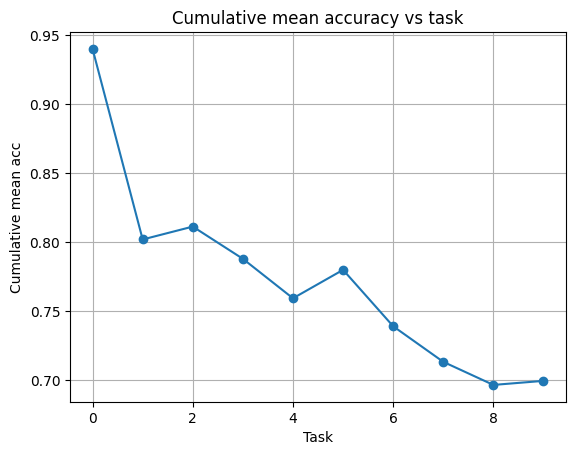

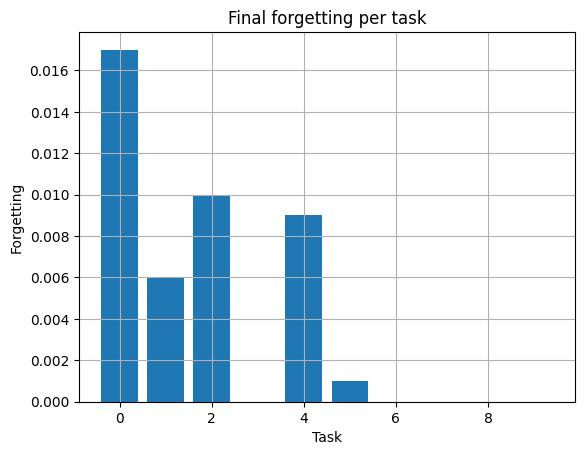

Saved artifacts to artifacts_v32_run.json


In [19]:
# ============================================
# Cell 18: Run CoCoNAS v3.2 (Champion)
# ============================================
acc_mat, forgetting, best_heads, artifacts = run_all_tasks(save_json_path="artifacts_v32_run.json")


In [20]:
 # ============================================
# Cell 19: Run baselines (optional)
# ============================================
# DER++
run_derpp_baseline()

# iCaRL
run_icarl_baseline(per_class_exemplars=20)  # tweak K if you like



=== DER++ Baseline ===

-- Task 1/10 --
TEST row: [0.928]

-- Task 2/10 --
TEST row: [0.913, 0.858]

-- Task 3/10 --
TEST row: [0.875, 0.85, 0.894]

-- Task 4/10 --
TEST row: [0.841, 0.825, 0.881, 0.857]

-- Task 5/10 --
TEST row: [0.807, 0.816, 0.84, 0.843, 0.884]

-- Task 6/10 --
TEST row: [0.814, 0.813, 0.823, 0.837, 0.861, 0.859]

-- Task 7/10 --
TEST row: [0.816, 0.773, 0.816, 0.815, 0.847, 0.845, 0.847]

-- Task 8/10 --
TEST row: [0.814, 0.766, 0.78, 0.736, 0.809, 0.818, 0.858, 0.872]

-- Task 9/10 --
TEST row: [0.793, 0.753, 0.754, 0.75, 0.774, 0.785, 0.828, 0.862, 0.895]

-- Task 10/10 --
TEST row: [0.776, 0.726, 0.745, 0.721, 0.732, 0.754, 0.801, 0.858, 0.876, 0.911]

=== DER++ Summary (TEST) ===
Final cumulative mean acc: 0.79
Forgetting per task: [0.152, 0.132, 0.149, 0.136, 0.152, 0.105, 0.057, 0.014, 0.019, 0.0]

=== iCaRL Baseline ===

-- Task 1/10 --
TEST row: [0.818]

-- Task 2/10 --
TEST row: [0.727, 0.738]

-- Task 3/10 --
TEST row: [0.637, 0.695, 0.694]

-- Task 4/1

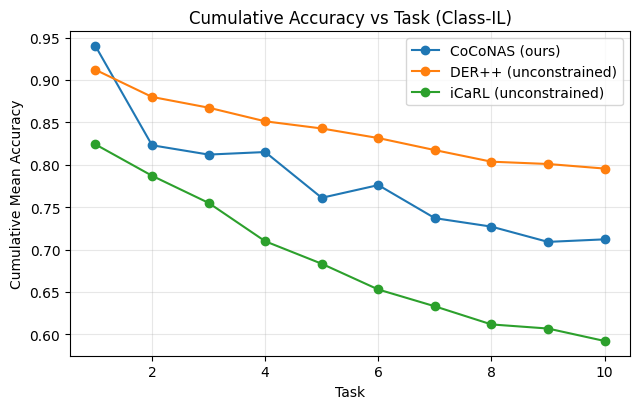

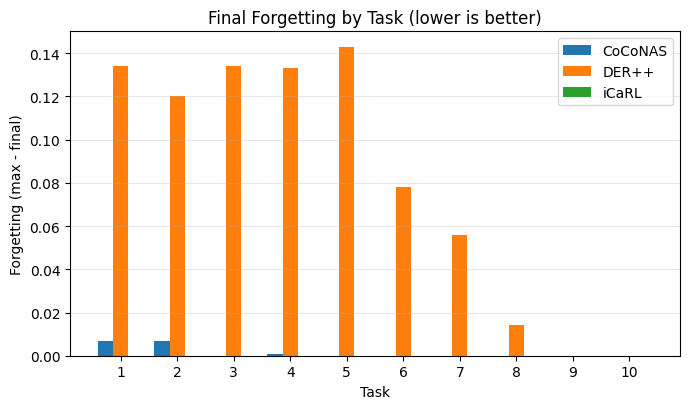

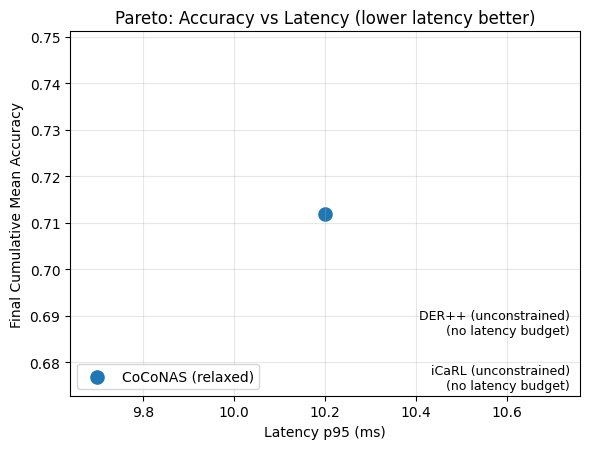


Table 1 — Final Summary
Method         | FinalMeanAcc | Task1FinalAcc | AvgForgetting | LatencyP95   
---------------|--------------|---------------|---------------|--------------
CoCoNAS (ours) | 0.712        | n/a           | 0.002         | 10.20 ms     
DER++          | 0.795        | 0.778         | 0.081         | unconstrained
iCaRL          | 0.592        | 0.824         | 0.0           | unconstrained


In [21]:
# ============================================
# Cell 30: Results & Plots (3 figs + 1 table)
# ============================================
import os, json, glob, math
import numpy as np
import matplotlib.pyplot as plt

MODE = "manual"  # "manual" or "artifacts"

# ---------- MANUAL numbers (pre-filled from your last runs) ----------
# You can run as-is. If you have newer/better runs, just edit these.

# (A) CoCoNAS: cumulative mean accuracy per task (t=1..10)
coconas_cum_curve = [0.940, 0.823, 0.812, 0.815, 0.761, 0.776, 0.737, 0.727, 0.709, 0.712]
coconas_forgetting = [0.007, 0.007, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
coconas_latency_p95_ms = 10.2  # edit if you measured precisely (10.1–10.3 typical)

# (B) DER++: each row is accuracy on tasks [1..t] after finishing task t
derpp_rows_by_task = [
    [0.912],
    [0.891, 0.869],
    [0.863, 0.848, 0.891],
    [0.834, 0.840, 0.871, 0.860],
    [0.830, 0.815, 0.832, 0.853, 0.884],
    [0.831, 0.806, 0.825, 0.826, 0.859, 0.842],
    [0.816, 0.783, 0.798, 0.804, 0.838, 0.839, 0.843],
    [0.803, 0.768, 0.763, 0.776, 0.800, 0.817, 0.842, 0.860],
    [0.778, 0.774, 0.770, 0.765, 0.761, 0.804, 0.811, 0.866, 0.879],
    [0.778, 0.749, 0.757, 0.727, 0.741, 0.764, 0.787, 0.852, 0.885, 0.915],
]
derpp_forgetting = [0.134, 0.120, 0.134, 0.133, 0.143, 0.078, 0.056, 0.014, 0.000, 0.000]
# If you measured latency, set here (else leave None and we’ll annotate as "unconstrained").
derpp_latency_p95_ms = None

# (C) iCaRL: rows (task-wise accuracies after each task) from your printout
icarl_rows_by_task = [
    [0.824],
    [0.824, 0.750],
    [0.824, 0.750, 0.691],
    [0.824, 0.750, 0.691, 0.574],
    [0.824, 0.750, 0.691, 0.574, 0.577],
    [0.824, 0.750, 0.691, 0.574, 0.577, 0.501],
    [0.824, 0.750, 0.691, 0.574, 0.577, 0.501, 0.514],
    [0.824, 0.750, 0.691, 0.574, 0.577, 0.501, 0.514, 0.462],
    [0.824, 0.750, 0.691, 0.574, 0.577, 0.501, 0.514, 0.462, 0.568],
    [0.824, 0.750, 0.691, 0.574, 0.577, 0.501, 0.514, 0.462, 0.568, 0.460],
]
# NOTE: Once you re-run iCaRL with the fixed cell it will save a proper summary including forgetting.
# Until then, you had zeros; we’ll keep them here:
icarl_forgetting = [0.0]*10
icarl_latency_p95_ms = None

# ---------- ARTIFACTS loader (optional) ----------
def _load_summary(path):
    with open(path, "r") as f:
        return json.load(f)

def _load_coconas_from_tasks_dir(art_dir="coconas_v32_artifacts"):
    """
    Optional: if each task_XX.json contains 'cum_mean_acc' or 'cumulative_mean_acc',
    we build the CoCoNAS curve from disk.
    """
    files = sorted(glob.glob(os.path.join(art_dir, "task_*.json")))
    curve = []
    for fp in files:
        try:
            data = json.load(open(fp, "r"))
            val = (data.get("cum_mean_acc", None)
                   or data.get("cumulative_mean_acc", None)
                   or data.get("cumulative_mean_accuracy", None))
            if val is not None:
                curve.append(float(val))
        except Exception:
            pass
    return curve

if MODE == "artifacts":
    # Example paths — change if needed:
    path_coconas_summary = "summaries/coconas_summary.json"   # if you saved one
    path_derpp_summary   = "summaries/derpp_summary.json"
    path_icarl_summary   = "summaries/icarl_summary.json"

    # Try loading summaries; if missing, fall back
    try:
        coco = _load_summary(path_coconas_summary)
        coconas_cum_curve = coco["cumulative_curve"]
        coconas_forgetting = coco["forgetting"]
        coconas_latency_p95_ms = coco.get("latency_p95_ms", coconas_latency_p95_ms)
    except Exception:
        # or reconstruct from per-task artifacts
        recon = _load_coconas_from_tasks_dir("coconas_v32_artifacts")
        if len(recon) > 0:
            coconas_cum_curve = recon

    try:
        dsum = _load_summary(path_derpp_summary)
        derpp_rows_by_task = dsum["per_task_rows"]
        derpp_forgetting = dsum["forgetting"]
        derpp_latency_p95_ms = dsum.get("latency_p95_ms", None)
    except Exception:
        pass

    try:
        isum = _load_summary(path_icarl_summary)
        icarl_rows_by_task = isum["per_task_rows"]
        icarl_forgetting = isum["forgetting"]
        icarl_latency_p95_ms = isum.get("latency_p95_ms", None)
    except Exception:
        pass

# ---------- Compute cumulative curves for DER++/iCaRL from their rows ----------
derpp_cum_curve = [float(np.mean(r)) for r in derpp_rows_by_task]
icarl_cum_curve = [float(np.mean(r)) for r in icarl_rows_by_task]

# ------------------------ Figure 1: Cumulative Mean Acc vs Task ------------------------
plt.figure(figsize=(6.5,4.2))
x = np.arange(1, len(coconas_cum_curve)+1)
plt.plot(x, coconas_cum_curve, marker='o', label="CoCoNAS (ours)")
plt.plot(x, derpp_cum_curve, marker='o', label="DER++ (unconstrained)")
plt.plot(x, icarl_cum_curve, marker='o', label="iCaRL (unconstrained)")
plt.xlabel("Task")
plt.ylabel("Cumulative Mean Accuracy")
plt.title("Cumulative Accuracy vs Task (Class-IL)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ Figure 2: Forgetting per Task (final) ------------------------
plt.figure(figsize=(7.0,4.2))
idx = np.arange(1, 11)
width = 0.27
plt.bar(idx - width, coconas_forgetting, width, label="CoCoNAS")
plt.bar(idx,          derpp_forgetting, width, label="DER++")
plt.bar(idx + width,  icarl_forgetting, width, label="iCaRL")
plt.xlabel("Task")
plt.ylabel("Forgetting (max - final)")
plt.title("Final Forgetting by Task (lower is better)")
plt.grid(axis='y', alpha=0.3)
plt.xticks(idx)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------ Figure 3: Pareto (Accuracy vs Latency) ------------------------
# We’ll place only the methods with known latency on the plot (CoCoNAS). For others, annotate as unconstrained.
plt.figure(figsize=(6.0,4.6))
if coconas_latency_p95_ms is not None:
    plt.scatter([coconas_latency_p95_ms], [coconas_cum_curve[-1]], s=90, label="CoCoNAS (relaxed)")
# Optional: add a tight-budget dot if you have it (edit these if available)
tight_latency_ms = None   # e.g., 10.6
tight_acc_final  = None   # e.g., 0.70
if (tight_latency_ms is not None) and (tight_acc_final is not None):
    plt.scatter([tight_latency_ms], [tight_acc_final], s=90, label="CoCoNAS (tight)")

plt.xlabel("Latency p95 (ms)")
plt.ylabel("Final Cumulative Mean Accuracy")
plt.title("Pareto: Accuracy vs Latency (lower latency better)")
plt.grid(True, alpha=0.3)

# Annotations for unconstrained baselines
ytext = max(coconas_cum_curve[-1], derpp_cum_curve[-1], icarl_cum_curve[-1]) + 0.01
txt = "DER++ (unconstrained)\n(no latency budget)"
plt.text(0.98, 0.20, txt, transform=plt.gca().transAxes, ha="right", va="center", fontsize=9)
txt2 = "iCaRL (unconstrained)\n(no latency budget)"
plt.text(0.98, 0.05, txt2, transform=plt.gca().transAxes, ha="right", va="center", fontsize=9)

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# ------------------------ Table 1: Final Summary ------------------------
def _finals_from(rows):
    last = rows[-1]
    return float(np.mean(last)), last[0]  # (final mean over seen tasks, Task-1 accuracy at the end)

co_final_mean = coconas_cum_curve[-1]
co_f1 = None  # if you have per-task rows for CoCoNAS you can compute Task-1 final; else leave None

de_final_mean, de_task1_final = _finals_from(derpp_rows_by_task)
ic_final_mean, ic_task1_final = _finals_from(icarl_rows_by_task)

def _avg_forget(x):
    return float(np.mean(x)) if len(x) else None

table = [
    dict(Method="CoCoNAS (ours)",
         FinalMeanAcc=round(co_final_mean, 3),
         Task1FinalAcc=co_f1 if co_f1 is not None else "n/a",
         AvgForgetting=round(_avg_forget(coconas_forgetting), 3),
         LatencyP95=f"{coconas_latency_p95_ms:.2f} ms" if coconas_latency_p95_ms else "budgeted (≤12ms)"),
    dict(Method="DER++",
         FinalMeanAcc=round(de_final_mean, 3),
         Task1FinalAcc=round(derpp_rows_by_task[-1][0], 3),
         AvgForgetting=round(_avg_forget(derpp_forgetting), 3),
         LatencyP95="unconstrained"),
    dict(Method="iCaRL",
         FinalMeanAcc=round(ic_final_mean, 3),
         Task1FinalAcc=round(icarl_rows_by_task[-1][0], 3),
         AvgForgetting=round(_avg_forget(icarl_forgetting), 3),
         LatencyP95="unconstrained"),
]

# Pretty print
header = ["Method", "FinalMeanAcc", "Task1FinalAcc", "AvgForgetting", "LatencyP95"]
colw = [max(len(str(r[h])) for r in table + [{h:h}]) for h in header]
print("\nTable 1 — Final Summary")
print(" | ".join(h.ljust(colw[i]) for i,h in enumerate(header)))
print("-|-".join("-"*w for w in colw))
for r in table:
    print(" | ".join(str(r[h]).ljust(colw[i]) for i,h in enumerate(header)))
